## Start spark session
This will be used by `TorchDistributor` to allocate the necessary memory space for each process.

In [1]:
from pyspark.ml.torch.distributor import TorchDistributor 
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
sc = SparkContext('local')
spark = SparkSession(sc)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/12/16 18:23:19 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Import libraries

In [2]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import torch
import random
import torch.nn as nn
import torch.optim as optim
import os
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data import DataLoader, TensorDataset
from scipy import stats
import time as time
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
import warnings
from datetime import datetime

warnings.filterwarnings("ignore", category=FutureWarning)
current_time = datetime.now().strftime('%d%m_%H%M%S')
base_directory = './trained_networks/'
new_directory = os.path.join(base_directory, current_time)
os.makedirs(new_directory, exist_ok=True)

# Training section

## Import the dataset

The dataset has been taken from [this link](http://www.timeseriesclassification.com/description.php?Dataset=ECG5000). It comprises 4998 stime series, each evaluated in 140 time points. An additional column is added for labels (1: normal, 0: anomalous) There are 2079 normal signals in total (41.6% of the total dataset).
* `input_dim`: number of time evaluations for each time series
* `encoding_dim`: number of encoded features in the latent space

In [3]:
random_SEED = 42
np.random.seed(random_SEED) # for reproducibility

df_raw_data = pd.read_csv('ECG5000/ecg.csv', header=None) # load data
df_raw_data.columns = [f't{i+1}' for i in range(df_raw_data.shape[1] - 1)] + ['label'] # set name for columns
torch_data_normal = torch.tensor(df_raw_data[df_raw_data['label'] == True].values[:,:-1], dtype=torch.float32) # transform to tensor (last column is for label)
torch_data_anomalous = torch.tensor(df_raw_data[df_raw_data['label'] == False].values[:,:-1], dtype=torch.float32) # transform to tensor (last column is for label)
hold_out_idx = torch.tensor(random.sample(range(torch_data_normal.shape[0]), 500)) # hold out some data for final testing
all_indices = torch.arange(torch_data_normal.shape[0]) 
remaining_indices = all_indices[~torch.isin(all_indices, hold_out_idx)]
hold_out_normal = torch_data_normal[hold_out_idx,:]
torch_data_normal = torch_data_normal[remaining_indices,:]
input_dim = torch_data_normal.shape[1]
encoding_dim = 10

# # Uncomment to increment the size of the training data to see if the notebook is scalable
# torch_data_normal = torch.concat((torch_data_normal,torch_data_normal,torch_data_normal,torch_data_normal,torch_data_normal,torch_data_normal,
#               torch_data_normal,torch_data_normal,torch_data_normal,torch_data_normal,torch_data_normal,
#               torch_data_normal,torch_data_normal,torch_data_normal,torch_data_normal,torch_data_normal))

print(f'Training data (normal): {torch_data_normal.shape[0]}')
print(f'Anomalous data: {torch_data_anomalous.shape[0]}')
print(f'Hold-out data (normal): {hold_out_normal.shape[0]}')
print(f'Total data: {hold_out_normal.shape[0]+torch_data_anomalous.shape[0]+torch_data_normal.shape[0]}')

Training data (normal): 2419
Anomalous data: 2079
Hold-out data (normal): 500
Total data: 4998


## Split the dataset inot `num_splits` chunks
* `num_splits`: number of processes to spawn / number of chunks to partition the dataset into

In [4]:
train_datasets = []

num_splits = 9
split_sizes = [torch_data_normal.shape[0] // num_splits] * (num_splits - 1) + [torch_data_normal.shape[0] - (torch_data_normal.shape[0] // num_splits) * (num_splits - 1)]
train_datasets = torch.split(torch_data_normal, split_sizes)
for tt_idx, tt in enumerate(train_datasets):
    print(f"{tt.shape[0]} data in chunk number {tt_idx+1}")

268 data in chunk number 1
268 data in chunk number 2
268 data in chunk number 3
268 data in chunk number 4
268 data in chunk number 5
268 data in chunk number 6
268 data in chunk number 7
268 data in chunk number 8
275 data in chunk number 9


## Define the model 
The same model will be used by each process

In [5]:
class TimeSeriesAutoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(TimeSeriesAutoencoder, self).__init__()
        self.encode = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, encoding_dim),
        )
        
        self.decode = nn.Sequential(
            nn.Linear(encoding_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, input_dim)
        )

    def forward(self, x):
        encoded = self.encode(x)
        decoded = self.decode(encoded)
        return decoded
    

models = [] # list of models
for i in range(num_splits): # initialize a model for each process, place them all into a list
    models.append(TimeSeriesAutoencoder(input_dim=input_dim, encoding_dim=encoding_dim))

In [6]:
def train_data_loader(split_index, datasets, batch_size):
    """
    This function creates the dataloader for each node.

    Parameters
    ----------
    split_index : (int)
        The number of the assigned node (0,1,...)
    datasets : (list)
        A list of datasets
    batch_size : (int)
        Size of the minibatch

    Returns
    -------
    A dataloader for the dataset at index split_index
    """

    train_dataset_split_index = TensorDataset(datasets[split_index]) 
    train_dataloader_split_index = DataLoader(train_dataset_split_index, batch_size=batch_size, shuffle=True)
    
    return(train_dataloader_split_index)

def training(models, train_datasets, criterion, num_epochs, batch_size, learning_rate, print_epoch):
    """
    This function is used for training.

    Parameters
    ----------
    models : [models]
        A list of models to be trained
    train_datasets : (list)
        A list of datasets to be used for training
    criterion : (function)
        Loss function
    num_epochs : (int)
        Number of epochs to be run
    batch_size : (int)
        Size of the minibatch
    learning_rate : (float)
        The learning rate for the optimizer
    print_epoch : (int)
        Determines if we print a loss and how often, set to 0 to omit print
    Returns
    -------
    A dataloader for the dataset at index split_index
    """

    local_rank = int(os.environ["LOCAL_RANK"]) # local rank of this process (used to access the corresponding model)
    
    model = models[local_rank] # access the model
    
    dataloader = train_data_loader(local_rank, train_datasets, batch_size) # load the data for this process
    
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    for epoch in range(1,num_epochs+1): # standard training loop in a batch-fashion
        total_loss = 0
        for batch in dataloader:
            inputs = batch[0]
            outputs = model(inputs)
            loss = criterion(outputs, inputs)  
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        if print_epoch != 0:
            if epoch % print_epoch == 0:
                print(f"Model {local_rank} Epoch [{epoch}/{num_epochs}], Loss: {total_loss/len(dataloader):.6f}")
    
    torch.save(model.state_dict(), new_directory + os.sep + "ensemble_" + str(local_rank) + ".pth") # save this model

    return 
    

In [7]:
criterion = nn.MSELoss()
num_epochs = 100
batch_size = 32
learning_rate = 0.01

print_epoch = 20 # print the loss function's value every 20 epochs

start_time = time.time()

# run takes arguments: (<function to be run>, <arguments to be passed to function>)
TorchDistributor(num_processes=num_splits, local_mode=True, use_gpu=False).run(training, # function to run
                models, train_datasets, criterion, num_epochs, batch_size, learning_rate, print_epoch) # arguments to pass to function

print('It took ' , time.time()-start_time ,'s')

Started local training with 9 processes


[2024-12-16 18:23:23,052] torch.distributed.elastic.multiprocessing.redirects: [WARNING] NOTE: Redirects are currently not supported in Windows or MacOs.
master_addr is only used for static rdzv_backend and when rdzv_endpoint is not specified.
*****************************************
Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
*****************************************
Model 1 Epoch [20/100], Loss: 0.080169
Model 7 Epoch [20/100], Loss: 0.074289
Model 6 Epoch [20/100], Loss: 0.080709
Model 8 Epoch [20/100], Loss: 0.081453
Model 2 Epoch [20/100], Loss: 0.075843
Model 5 Epoch [20/100], Loss: 0.078803
Model 0 Epoch [20/100], Loss: 0.081247
Model 3 Epoch [20/100], Loss: 0.072051
Model 4 Epoch [20/100], Loss: 0.080742
Model 1 Epoch [40/100], Loss: 0.046069
Model 7 Epoch [40/100], Loss: 0.052171
Model 6 Epoch [40/100], Loss: 0.04

Finished local training with 9 processes


It took  6.984447002410889 s


# Inference section

## Load models

In [8]:
# loads the trained models from the folder trained_networks/example
models = []
for i in range(num_splits):
    models.append(TimeSeriesAutoencoder(input_dim=input_dim, encoding_dim=encoding_dim))
    models[i].load_state_dict(torch.load(new_directory + os.sep + "ensemble_" + str(i) + ".pth", weights_only=True))
    models[i].eval()

/Users/micheledisabato/Library/Python/3.9/lib/python/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


## Apply models to never-before-seen signals
The first 500 data in `new_patients` are normal signals, the last 500 are anomalies.

In [9]:
new_patients = torch.concat((hold_out_normal, torch_data_anomalous[torch.tensor(random.sample(range(torch_data_anomalous.shape[0]), 500)),:]))
true_labels = torch.concat((torch.ones(500), torch.zeros(500))).numpy() # 500 normals + 500 anomalous
mse_loss = nn.MSELoss()

reconstructed_new_patients_all = []
result_all = [] 
with torch.no_grad(): # ensure that gradients will not be changed
    for i in range(num_splits): # for each process/model...
        i_model = models[i] # load the model
        i_model.eval() # ensure that gradients will not be changed
        reconstructed_new_patients_i = i_model(new_patients) # reconstruct the never-before-seen signals
        reconstructed_new_patients_all.append(reconstructed_new_patients_i)
        new_patients_loss_i = []
        normal_loss_i = []
        for j in range(train_datasets[i].shape[0]): # compute reconstruction losses on training data
            normal_loss_i.append(mse_loss(i_model(train_datasets[i][j,:]), train_datasets[i][j,:]).numpy())
        for j in range(new_patients.shape[0]): # compute reconstruction losses on new data
            new_patients_loss_i.append(mse_loss(reconstructed_new_patients_i[j,:], new_patients[j,:]).numpy())
        normal_ecdf_i = stats.ecdf(normal_loss_i) # compute the Empirical Cumulative Density Function of the reconstruction losses of the training (healthy) ECGs
        result_i = normal_ecdf_i.cdf.evaluate(new_patients_loss_i) # evaluate the ECDF on the reconstruction losses of the new time series
        result_all.append(result_i)

## Plot the anomaly scores on never-before-seen data
The y-axis of these plots represent the anomaly scores, which are in [0, 1] by construction (the anomaly score is a probability)

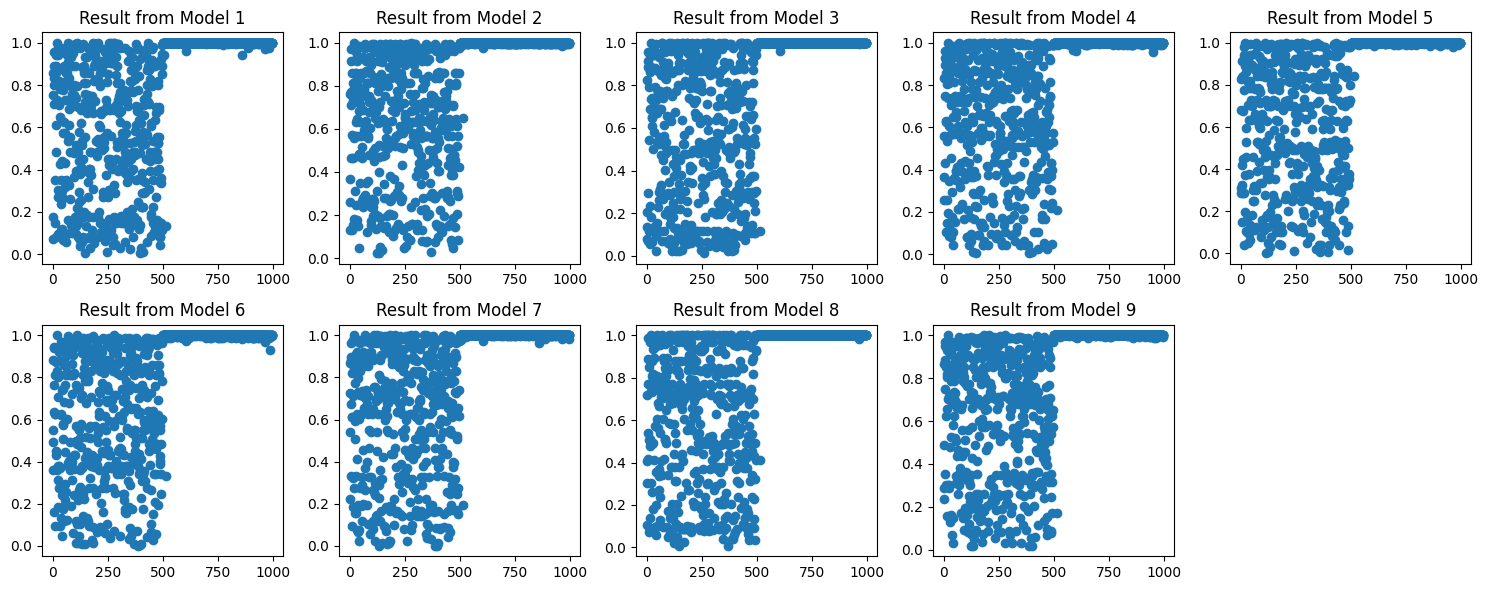

In [10]:
max_cols = 5 # for plotting purposes
max_rows = int(np.ceil(num_splits / 5)) # for plotting purposes
plt.figure(figsize=(15, max_rows * 3)) 
for i in range(num_splits):
    plt.subplot(max_rows, max_cols, i + 1) 
    plt.scatter(range(len(result_all[i])), result_all[i])
    plt.title(f"Result from Model {i+1}")
plt.tight_layout()
plt.show()

## Set threshold, evaluate performance of the ensemble

Confusion Matrix from model 1:
[[497   3]
 [ 52 448]]
Accuracy from model 1: 0.945
Precision from model 1: 0.9933481152993349
Recall from model 1: 0.896
Confusion Matrix from model 2:
[[499   1]
 [ 71 429]]
Accuracy from model 2: 0.928
Precision from model 2: 0.9976744186046511
Recall from model 2: 0.858
Confusion Matrix from model 3:
[[499   1]
 [ 74 426]]
Accuracy from model 3: 0.925
Precision from model 3: 0.9976580796252927
Recall from model 3: 0.852
Confusion Matrix from model 4:
[[499   1]
 [ 71 429]]
Accuracy from model 4: 0.928
Precision from model 4: 0.9976744186046511
Recall from model 4: 0.858
Confusion Matrix from model 5:
[[499   1]
 [ 60 440]]
Accuracy from model 5: 0.939
Precision from model 5: 0.9977324263038548
Recall from model 5: 0.88
Confusion Matrix from model 6:
[[498   2]
 [ 65 435]]
Accuracy from model 6: 0.933
Precision from model 6: 0.9954233409610984
Recall from model 6: 0.87
Confusion Matrix from model 7:
[[499   1]
 [ 82 418]]
Accuracy from model 7: 0.917
P

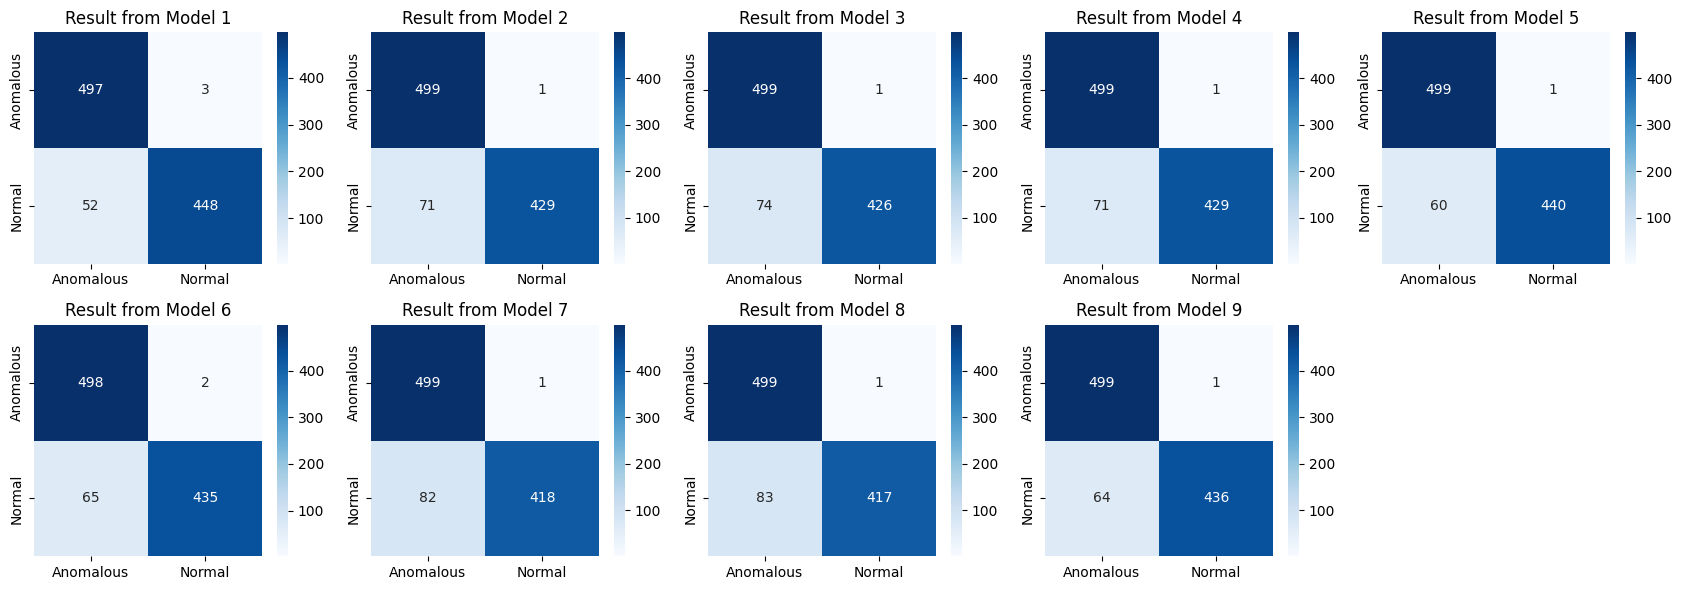

In [11]:
alpha = 0.05

selected_indices_all = []
predicted_labels_all = []
cm_all = []
accuracy_all = []
precision_all = []
recall_all = []

for i in range(num_splits):
    result_i = result_all[i]
    selected_indices_i = np.where(result_i > 1-alpha)
    selected_indices_all.append(selected_indices_i)
    selected_values_i = result_i[selected_indices_i]

    predicted_labels_i = np.ones_like(true_labels)
    predicted_labels_i[selected_indices_i] = 0
    predicted_labels_all.append(predicted_labels_i)

    cm_i = confusion_matrix(true_labels, predicted_labels_i)
    cm_all.append(cm_i)

    print(f"Confusion Matrix from model {i+1}:")
    print(cm_i)

    accuracy_i = accuracy_score(true_labels, predicted_labels_i)
    accuracy_all.append(accuracy_i)
    precision_i = precision_score(true_labels, predicted_labels_i)
    precision_all.append(precision_i)
    recall_i = recall_score(true_labels, predicted_labels_i)
    recall_all.append(recall_i)

    print(f"Accuracy from model {i+1}: {accuracy_i}")
    print(f"Precision from model {i+1}: {precision_i}")
    print(f"Recall from model {i+1}: {recall_i}")

plt.figure(figsize=(17, max_rows * 3)) 
for i in range(num_splits):
    plt.subplot(max_rows, max_cols, i + 1) 
    sns.heatmap(cm_all[i], annot=True, fmt="d", cmap="Blues", xticklabels=['Anomalous', 'Normal'], yticklabels=['Anomalous', 'Normal'])
    plt.title(f"Result from Model {i+1}")
plt.tight_layout()
plt.show()

## Merge results
The anomaly score of the ensemble is the sample average of the anomaly scores of the models.

Confusion for the ensemble:
[[499   1]
 [ 58 442]]
Accuracy for the ensemble: 0.941
Precision for the ensemble: 0.9977426636568849
Recall for the ensemble: 0.884


<Axes: >

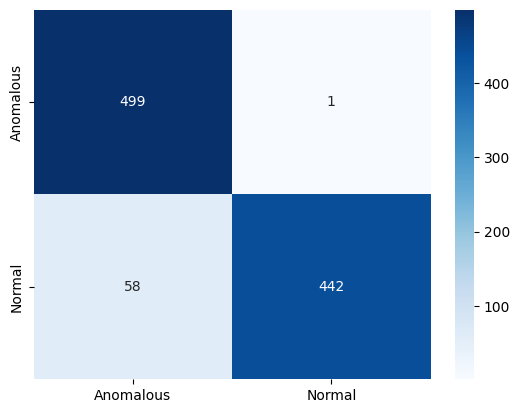

In [12]:
alpha = 0.05

result_merged = np.array([sum(x)/num_splits for x in zip(*result_all)])

selected_indices_merged = np.where(result_merged > 1-alpha)
selected_values_merged = result_i[selected_indices_merged]

predicted_labels_merged = np.ones_like(true_labels)
predicted_labels_merged[selected_indices_merged] = 0

cm_merged = confusion_matrix(true_labels, predicted_labels_merged)

print(f"Confusion for the ensemble:")
print(cm_merged)

accuracy_merged = accuracy_score(true_labels, predicted_labels_merged)
precision_merged = precision_score(true_labels, predicted_labels_merged)
recall_merged = recall_score(true_labels, predicted_labels_merged)

print(f"Accuracy for the ensemble: {accuracy_merged}")
print(f"Precision for the ensemble: {precision_merged}")
print(f"Recall for the ensemble: {recall_merged}")

sns.heatmap(cm_merged, annot=True, fmt="d", cmap="Blues", xticklabels=['Anomalous', 'Normal'], yticklabels=['Anomalous', 'Normal'])

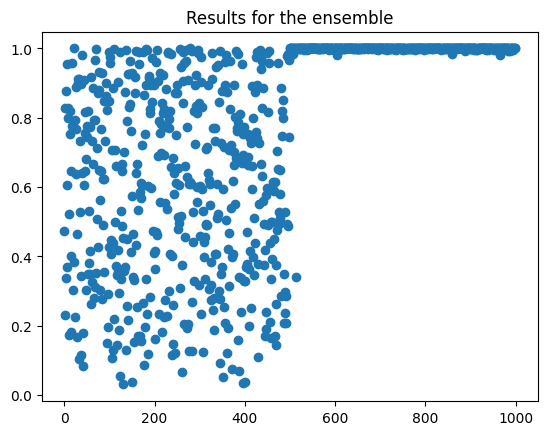

In [13]:
plt.scatter(range(len(result_merged)), result_merged)
plt.title(f"Results for the ensemble")
plt.show()